In [1]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_default_device", jax.devices()[1])

import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm
plt.style.use("ggplot")

from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *
from EquationModel import OperatorModel,SplitOperatorPDEModel,OperatorPDEModel,build_batched_jac_func,InducedOperatorModel
from evaluation_metrics import compute_results    
from data_utils import MinMaxScaler
from evaluation_metrics import get_nrmse

from Kernels import log1pexp,inv_log1pexp
from Kernels import (
    get_centered_scaled_poly_kernel,
    get_anisotropic_gaussianRBF,
    fit_kernel_params
)
from EquationModel import CholInducedRKHS, CholOperatorModel, OperatorPDEModel
from functools import partial

import Optimizers
import importlib
importlib.reload(Optimizers)
from Optimizers import CholeskyLM,SVD_LM,SketchedLM
import scipy

In [58]:
def get_data_rand_coll(n_coll, n_obs,seed, data_for_pinn = False): 
    '''
    n_coll (int) : Integer less than 101 x 256.
    n_obs (int)    : Integet less than n_coll.
    seed (int)     : Seed to choose data point set.
    '''     
    # Generate data
    data = scipy.io.loadmat('/home/juanfelipe/Desktop/research/keql/examples/burgers/data/burgers.mat')
    # t
    t = jnp.real(data['t'].flatten()[:,None])
    # # Scale t
    # scaler_t = MinMaxScaler()
    # t = scaler_t.fit_transform(t)
    # x
    x = np.real(data['x'].flatten()[:,None])
    # # Scale x
    # scaler_x = MinMaxScaler()
    # x = scaler_x.fit_transform(x)
    # u true values
    Exact = np.real(data['usol'])

    # Fine meshgrid
    T, X = np.meshgrid(t,x)

    # Fine pairs (t,x)
    X_star = np.hstack((T.flatten()[:,None], X.flatten()[:,None]))
    # Fine u values
    u_star = Exact.flatten()[:,None]
    
    # Triples at collocation point set
    N_all = n_coll
    triplets_fine = np.hstack([X_star,u_star])
    triplets_all = jax.random.choice(key = jax.random.PRNGKey(0), a = triplets_fine, shape = (N_all,), replace=False)
    
    # Collocation point set
    tx_all = triplets_all[:,:2]


    N_obs = n_obs
    triplets_obs = jax.random.choice(key = jax.random.PRNGKey(seed), a = triplets_fine, shape = (N_obs,), replace=False)
    # triplets_obs = triplets_all[idx_obs,:] # Choose data point set from collocation point set
    # Data point set
    tx_obs = triplets_obs[:,:2]
    u_obs = triplets_obs[:,-1]

    u_star = triplets_fine[:,-1]

    # Invert them to be ready for PINNSR
    if data_for_pinn:
        tx_train = tx_train.at[:,[1,0]].set(tx_train[:,[0,1]])

        tx_val = tx_val.at[:,[1,0]].set(tx_val[:,[0,1]])

        tx_all = tx_all.at[:,[1,0]].set(tx_all[:,[0,1]])

        X_star = X_star.at[:,[1,0]].set(X_star[:,[0,1]])

        triplets_fine = triplets_fine.at[:,[1,0]].set(triplets_fine[:,[0,1]])
    
    return tx_obs, u_obs, tx_all, u_star, X_star

import time
from jax.scipy.linalg import solve

import time
from jax.scipy.linalg import solve
from dataclasses import dataclass, field

@dataclass
class LMParams:
    """
    max_iter : int, optional
        by default 201
    tol : float, optional
        Gradient norm stopping tolerance
    cmin : float, optional
        Minimum armijo ratio to accept step, by default 0.1
    line_search_increase_ratio : float, optional
        constant to increase reg strength by in backtracking line search, by default 1.5
    max_line_search_iterations : int, optional
        by default 20
    min_alpha : float, optional
        min damping strength, by default 1e-6
    max_alpha : float, optional
        max damping strength, by default 50.
    init_alpha : float, optional
        initial damping strength, by default 3.
    step_adapt_multipler : float, optional
        value to use for adapting alpha, by default 1.2
    callback : callable, optional
        function called to print another loss each iteration, by default None
    print_every : int, optional
        How often to print convergence data, by default 50
    """
    max_iter: int = 201
    tol: float = 1e-8
    cmin: float = 0.05
    line_search_increase_ratio: float = 1.5
    max_line_search_iterations: int = 20
    min_alpha: float = 1e-6
    max_alpha: float = 50.0
    init_alpha: float = 3.0
    step_adapt_multiplier: float = 1.2
    callback: callable = None
    print_every: int = 50
    track_iterates: bool = False

@dataclass
class ConvergenceHistory:
    track_iterates: bool = False
    loss_vals: list = field(default_factory=list)
    JtRes: list = field(default_factory=list)
    iterate_history: list = field(default_factory=list)
    improvement_ratios: list = field(default_factory=list)
    alpha_vals: list = field(default_factory=list)
    cumulative_time: list = field(default_factory=list)

    def update(
        self,
        loss,
        JtRes,
        iterate,
        armijo_ratio,
        alpha,
        cumulative_time
        ):
        # Append the new values to the corresponding lists
        self.loss_vals.append(loss)
        self.JtRes.append(JtRes)
        self.improvement_ratios.append(armijo_ratio)
        self.alpha_vals.append(alpha)
        self.cumulative_time.append(cumulative_time)
        
        # Conditionally track iterates if enabled
        if self.track_iterates:
            self.iterate_history.append(iterate)

    def finish(self):
        # Convert lists to JAX arrays
        self.loss_vals = jnp.array(self.loss_vals)
        self.JtRes = jnp.array(self.JtRes)
        self.improvement_ratios = jnp.array(self.improvement_ratios)
        self.alpha_vals = jnp.array(self.alpha_vals)
        self.cumulative_time = jnp.array(self.cumulative_time)
        if self.track_iterates:
            self.iterate_history = jnp.array(self.iterate_history)

def RefactoredCholeskyLM(
        init_params,
        model,
        beta,
        optParams: LMParams = LMParams()
        ):
    """Adaptively regularized Levenberg Marquardt optimizer
    Parameters
    ----------
    init_params : jax array
        initial guess
    model :
        Object that contains model.F, and model.jac, and model.damping_matrix
    beta : float
        (global) regularization strength
    optParams: LMParams
        optimizer hyperparameters

    Returns
    -------
    solution
        approximate minimizer
    convergence_dict
        dictionary of data tracking convergence
    """
    conv_history = ConvergenceHistory(optParams.track_iterates)
    start_time = time.time()
    params = init_params.copy()
    J = model.jac(params)
    residuals = model.F(params)
    damping_matrix = model.damping_matrix(params)
    alpha = optParams.init_alpha

    conv_history.update(
        loss = (1/2)*jnp.sum(residuals**2) + (1/2)*beta * params.T@damping_matrix@params,
        JtRes = jnp.linalg.norm(J.T@residuals + beta * damping_matrix@params),
        iterate = params,
        armijo_ratio = 1.,
        alpha = alpha,
        cumulative_time = time.time() - start_time
    )

    # TODO: This pair of functions can be handled more elegantly
    # Make something like an objective_data object
    @jax.jit
    def evaluate_objective(params):
        J = model.jac(params)
        residuals = model.F(params)
        damping_matrix = model.damping_matrix(params)
        loss = (1/2)*jnp.sum(residuals**2) + (1/2)*beta * params.T@damping_matrix@params
        JtJ = J.T@J
        rhs = J.T@residuals + beta * damping_matrix@params
        return J,residuals,damping_matrix,loss,JtJ,rhs
    
    @jax.jit
    def compute_step(params,alpha,J,JtJ,residuals,rhs,previous_loss,damping_matrix):
        M = JtJ + (alpha + beta) * damping_matrix
        step = solve(M,rhs,assume_a = 'pos')
        new_params = params - step
        new_reg_norm = beta * new_params.T@damping_matrix@new_params
        new_loss = (1/2)*(jnp.sum(model.F(new_params)**2) + new_reg_norm)
        predicted_loss = (1/2)*(jnp.sum((J@step-residuals)**2) + new_reg_norm)
        improvement_ratio = (previous_loss - new_loss)/(previous_loss - predicted_loss)
        return step,new_params,new_loss,improvement_ratio

    def LevenbergMarquadtUpdate(params,alpha):
        J,residuals,damping_matrix,loss,JtJ,rhs = evaluate_objective(params)
        alpha =jnp.clip(alpha,optParams.min_alpha,optParams.max_alpha)
        for i in range(optParams.max_line_search_iterations):

            step,new_params,new_loss,improvement_ratio = (
                compute_step(params,alpha,J,JtJ,residuals,rhs,loss,damping_matrix)
            )
            if improvement_ratio >= optParams.cmin:
                #Check if we get at least some proportion of predicted improvement from local model
                succeeded = True
                return new_params, new_loss, rhs, improvement_ratio,alpha,succeeded
            else:
                alpha = optParams.line_search_increase_ratio * alpha
            succeeded = False
        return new_params, new_loss, rhs, improvement_ratio,alpha,succeeded

    for i in tqdm(range(optParams.max_iter)):
        params,loss,rhs,improvement_ratio,alpha,succeeded = LevenbergMarquadtUpdate(params,alpha)
        # Get new value for alpha
        multiplier = optParams.step_adapt_multiplier
        if improvement_ratio <= 0.2:
            alpha = multiplier * alpha
        if improvement_ratio >= 0.8:
            alpha = alpha/multiplier

        if succeeded==False:
            print("Line Search Failed!")
            print("Final Iteration Results")
            print(
                f"Iteration {i}, loss = {loss:.4},"
                f" Jres = {conv_history.JtRes[-1]:.4}, alpha = {alpha:.4},"
                f" improvement_ratio = {improvement_ratio:.4}"
                )
            conv_history.finish()
            return params,conv_history

        conv_history.update(
            loss = loss,
            JtRes = jnp.linalg.norm(rhs),
            iterate = params,
            armijo_ratio = improvement_ratio,
            alpha = alpha,
            cumulative_time = time.time() - start_time
        )

        if conv_history.JtRes[-1]<=optParams.tol:
            break
        if i%optParams.print_every ==0 or i<=5 or i == optParams.max_iter:
            print(
                f"Iteration {i}, loss = {loss:.4},"
                f" Jres = {conv_history.JtRes[-1]:.4}, alpha = {alpha:.4},"
                f" improvement_ratio = {improvement_ratio:.4}"
                )
            if optParams.callback:
                optParams.callback(params)
    conv_history.finish()
    return params,conv_history


In [ ]:
def RefactoredCholeskyLM(
        init_params,
        model,
        beta,
        optParams: LMParams = LMParams()
        ):
    """Adaptively regularized Levenberg Marquardt optimizer
    Parameters
    ----------
    init_params : jax array
        initial guess
    model :
        Object that contains model.F, and model.jac, and model.damping_matrix
    beta : float
        (global) regularization strength
    optParams: LMParams
        optimizer hyperparameters

    Returns
    -------
    solution
        approximate minimizer
    convergence_dict
        dictionary of data tracking convergence
    """
    conv_history = ConvergenceHistory(optParams.track_iterates)
    start_time = time.time()
    params = init_params.copy()
    J = model.jac(params)
    residuals = model.F(params)
    damping_matrix = model.damping_matrix(params)
    alpha = optParams.init_alpha

    conv_history.update(
        loss = (1/2)*jnp.sum(residuals**2) + (1/2)*beta * params.T@damping_matrix@params,
        JtRes = jnp.linalg.norm(J.T@residuals + beta * damping_matrix@params),
        iterate = params,
        armijo_ratio = 1.,
        alpha = alpha,
        cumulative_time = time.time() - start_time
    )

    @jax.jit
    def evaluate_objective(params):
        J = model.jac(params)
        residuals = model.F(params)
        damping_matrix = model.damping_matrix(params)
        loss = (1/2)*jnp.sum(residuals**2) + (1/2)*beta * params.T@damping_matrix@params
        JtJ = J.T@J
        rhs = J.T@residuals + beta * damping_matrix@params
        return J,residuals,damping_matrix,loss,JtJ,rhs
    
    @jax.jit
    def compute_step(alpha,JtJ,rhs,previous_loss):
        M = JtJ + (alpha + beta) * damping_matrix
        step = solve(M,rhs,assume_a = 'pos')
        new_params = params - step
        new_reg_norm = beta * new_params.T@damping_matrix@new_params
        new_loss = (1/2)*(jnp.sum(model.F(new_params)**2) + new_reg_norm)
        predicted_loss = (1/2)*(jnp.sum((J@step-residuals)**2) + new_reg_norm)
        improvement_ratio = (previous_loss - new_loss)/(previous_loss - predicted_loss)
        return new_params,new_loss,improvement_ratio

    def LevenbergMarquadtUpdate(params,alpha):
        """TODO: Wrap up this into something a little more modular"""

        J,residuals,damping_matrix,loss,JtJ,rhs = evaluate_objective(params)
        alpha =jnp.clip(alpha,optParams.min_alpha,optParams.max_alpha)
        for i in range(optParams.max_line_search_iterations):
            new_params,new_loss,improvement_ratio = compute_step(alpha,JtJ,rhs,previous_loss = loss)

            if improvement_ratio >= optParams.cmin:
                #Check if we get at least some proportion of predicted improvement from local model
                succeeded = True
                return new_params, new_loss, rhs, improvement_ratio,alpha,succeeded
            else:
                alpha = optParams.line_search_increase_ratio * alpha
            succeeded = False
        return new_params, new_loss, rhs, improvement_ratio,alpha,succeeded

    for i in tqdm(range(optParams.max_iter)):
        params,loss,rhs,improvement_ratio,alpha,succeeded = LevenbergMarquadtUpdate(params,alpha)
        # Get new value for alpha
        multiplier = optParams.step_adapt_multiplier
        if improvement_ratio <= 0.2:
            alpha = multiplier * alpha
        if improvement_ratio >= 0.8:
            alpha = alpha/multiplier

        if succeeded==False:
            print("Line Search Failed!")
            print("Final Iteration Results")
            print(
                f"Iteration {i}, loss = {loss:.4},"
                f" Jres = {conv_history.JtRes[-1]:.4}, alpha = {alpha:.4},"
                f" improvement_ratio = {improvement_ratio:.4}"
                )
            conv_history.finish()
            return params,conv_history

        conv_history.update(
            loss = loss,
            JtRes = jnp.linalg.norm(rhs),
            iterate = params,
            armijo_ratio = improvement_ratio,
            alpha = alpha,
            cumulative_time = time.time() - start_time
        )

        if conv_history.JtRes[-1]<=optParams.tol:
            break
        if i%optParams.print_every ==0 or i<=5 or i == optParams.max_iter:
            print(
                f"Iteration {i}, loss = {loss:.4},"
                f" Jres = {conv_history.JtRes[-1]:.4}, alpha = {alpha:.4},"
                f" improvement_ratio = {improvement_ratio:.4}"
                )
            if optParams.callback:
                optParams.callback(params)
    conv_history.finish()
    return params,conv_history


In [33]:
# n_coll_t = 30
# n_coll_x=30
n_obs = 50
run = 100

n_coll = 200

tx_obs, u_obs, tx_all, u_star, X_star = (
    get_data_rand_coll(n_coll = n_coll,n_obs = n_obs,seed=run)
)
tx_all = jnp.vstack([tx_all,jnp.vstack([jnp.zeros(30),jnp.linspace(-8,8,30)]).T])

# Run 1_5 step method

u_operators = (eval_k,)
feature_operators = (eval_k,dx_k,dxx_k)

# Choose u kernel
def param_ani_gaussian_RBF(x,y,params):
    lengthscales = log1pexp(params)
    return get_anisotropic_gaussianRBF(1.,jnp.diag(lengthscales))(x,y)

fitted_params,ml_value = fit_kernel_params(param_ani_gaussian_RBF,tx_obs,u_obs,jnp.zeros(2))
ML_lengthscales = log1pexp(fitted_params)
print(1/(jnp.sqrt(ML_lengthscales)))
k_u = get_anisotropic_gaussianRBF(1.,jnp.diag(jnp.array([1.,1.])))

# RKHS class for u
u_model = CholInducedRKHS(
    tx_all,
    u_operators,
    k_u,
    nugget_size = 1e-8
    )
u_params_init = u_model.get_fitted_params(tx_obs,u_obs)

grid_features_init = (
    (u_model.evaluate_operators(feature_operators,tx_all,u_params_init))
    .reshape(
            len(tx_all),
            len(feature_operators),
            order = 'F'
        )
)
grid_features_init = jnp.hstack([tx_all,grid_features_init])
num_P_inducing = 500
P_inducing_points = jax.random.choice(jax.random.PRNGKey(13),grid_features_init,(num_P_inducing,))


# Choose kernel for P
k_P_u_part = get_centered_scaled_poly_kernel(2,grid_features_init[:,2:],c=1.,scaling = 'diagonal')

def k_P(x,y):
    return k_P_u_part(x[2:],y[2:])
P_model = InducedOperatorModel(P_inducing_points,k_P)

# Equation model that has u and P object
EqnModel = SplitOperatorPDEModel(
    P_model,
    (u_model,),
    (tx_obs,),
    (u_obs,),
    (tx_all,),
    feature_operators,
    rhs_operator=dt_k,
    datafit_weight = 100,
    num_P_operator_params=num_P_inducing
)
ut_init = EqnModel.apply_rhs_op_single(u_model,u_params_init,EqnModel.collocation_points[0])
P_params_init = P_model.get_fitted_params(grid_features_init,ut_init,lam = 1e-3)
params_init = jnp.hstack([u_params_init,P_params_init])

[2.03724345 2.01946685]


In [48]:
params,convergence_data = CholeskyLM(
    params_init.copy(),
    EqnModel,
    beta = 0.,
    max_iter = 201,
    init_alpha=3.,
    print_every = 50,
)

  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 0.001958, Jres = 0.01021, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 0.00193, Jres = 0.008847, alpha = 2.083, improvement_ratio = 1.001
Iteration 2, loss = 0.001899, Jres = 0.008293, alpha = 1.736, improvement_ratio = 1.001
Iteration 3, loss = 0.001864, Jres = 0.008006, alpha = 1.447, improvement_ratio = 1.002
Iteration 4, loss = 0.001824, Jres = 0.007814, alpha = 1.206, improvement_ratio = 1.003
Iteration 5, loss = 0.001777, Jres = 0.007667, alpha = 1.005, improvement_ratio = 1.004
Iteration 50, loss = 9.336e-06, Jres = 0.000408, alpha = 0.0002747, improvement_ratio = 1.027
Iteration 100, loss = 1.552e-06, Jres = 8.74e-06, alpha = 8.333e-07, improvement_ratio = 0.9992
Iteration 150, loss = 1.429e-06, Jres = 8.735e-07, alpha = 8.333e-07, improvement_ratio = 1.001
Iteration 200, loss = 1.387e-06, Jres = 6.355e-07, alpha = 8.333e-07, improvement_ratio = 1.002


In [59]:
optparams = LMParams(max_iter = 10)

params,convergence = RefactoredCholeskyLM(params_init.copy(),EqnModel,beta = 0.)#,optParams = optparams)

  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 0.001958, Jres = 0.01021, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 0.00193, Jres = 0.008847, alpha = 2.083, improvement_ratio = 1.001
Iteration 2, loss = 0.001899, Jres = 0.008293, alpha = 1.736, improvement_ratio = 1.001
Iteration 3, loss = 0.001864, Jres = 0.008006, alpha = 1.447, improvement_ratio = 1.002
Iteration 4, loss = 0.001824, Jres = 0.007814, alpha = 1.206, improvement_ratio = 1.003
Iteration 5, loss = 0.001777, Jres = 0.007667, alpha = 1.005, improvement_ratio = 1.004
Iteration 50, loss = 9.336e-06, Jres = 0.000408, alpha = 0.0002747, improvement_ratio = 1.027
Iteration 100, loss = 1.552e-06, Jres = 8.74e-06, alpha = 8.333e-07, improvement_ratio = 0.9992
Iteration 150, loss = 1.429e-06, Jres = 8.735e-07, alpha = 8.333e-07, improvement_ratio = 1.001
Iteration 200, loss = 1.387e-06, Jres = 6.355e-07, alpha = 8.333e-07, improvement_ratio = 1.002


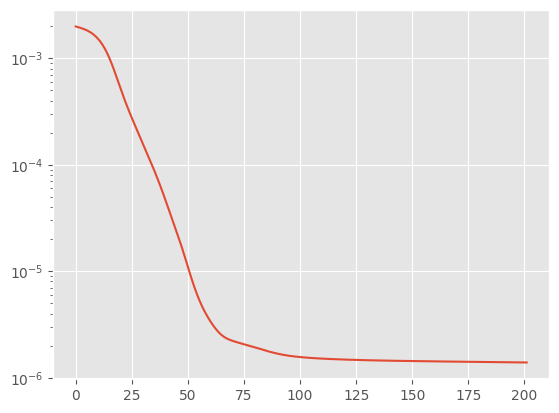

In [7]:
plt.plot(convergence.loss_vals)
plt.yscale('log')